# Signal check: r941 fast basecalling

> comparing workflows for viral genome assembly from minion amplicon-based sequencing with fast base calling

***

## Overview

* download the data
    - viral reference genomes from RefSeq
    - 3 Ebola virus (EBOV) MinIon samples
        - multiplexed on one flowcell
        - the basecalled reads from this run are already in this repository

* assemble the samples using the de novo pipeline
    - demux and trim the basecalled reads
    - assemble (miniasm / redbean)
    - correct the assemblies (racon x4 iterations)
    - polish, either:
        - without signal (medaka)
        - with signal (nanopolish)
        - with signal and without (nanopolish then medaka)
        - without and with (medaka then nanopolish)

* assess all the de novo assemblies for each sample
    - stats (quast)
    - find closest reference matches in refseq (fastani)
    - check nucleotide and structural differences (nucdiff)
    - visualise (msa)
   
* assemble the samples using the reference guided pipeline
    - select appropriate reference from refseq using the de novo assembly
    - assemble with rebaler

* assess all the reference guided assemblies for each sample
    - stats (quast)
    - check nucleotide and structural differences (nucdiff)


## 1. Download the data

* download the complete ebola assemblies from RefSeq

In [1]:
!ncbi-genome-download --format fasta --assembly-level complete --fuzzy-genus --genus ebola viral -o tmp --parallel 8 --retries 2

* download the Ebola virus Nanopore data from the [artic data releases](http://artic.network/protocol_validation_2019.html)
    * we are using the Ebola virus (EBOV) minion run that amplicon sequenced 3 strains of the virus (Mayinga, Kikwit, Makona) using the rapid PCR kit

In [1]:
!wget http://artic.s3.climb.ac.uk/run-folders/EBOV_Metagenomics.tar.gz --directory-prefix=tmp/
!tar -xvf tmp/EBOV_Metagenomics.tar.gz -C tmp/ --strip-components=1

--2019-10-08 14:36:27--  http://artic.s3.climb.ac.uk/run-folders/EBOV_Metagenomics.tar.gz
Resolving artic.s3.climb.ac.uk (artic.s3.climb.ac.uk)... 137.205.52.6
Connecting to artic.s3.climb.ac.uk (artic.s3.climb.ac.uk)|137.205.52.6|:80... connected.
HTTP request sent, awaiting response... 
  HTTP/1.1 200 OK
  Server: nginx/1.14.0
  Date: Tue, 08 Oct 2019 13:36:28 GMT
  Content-Type: application/gzip
  Content-Length: 1070346070
  Connection: keep-alive
  Accept-Ranges: bytes
  Last-Modified: Tue, 03 Sep 2019 15:29:47 GMT
  ETag: "6e2449545dc6d1ac030505b880132e29-8"
  x-amz-meta-s3cmd-attrs: atime:1567522299/ctime:1567522360/gid:1000/gname:artic/md5:eb30cd588722793c39455ceb97898874/mode:33188/mtime:1567522310/uid:1000/uname:artic
  x-amz-request-id: tx000000000000000017d35-005d9c90db-358ae6ba-s3-warwick
Length: 1070346070 (1021M) [application/gzip]
Saving to: ‘tmp/EBOV_Metagenomics.tar.gz’

EBOV_Metagenomics.t 100%[===================>]   1021M  2.51MB/s    in 7m 44s  

2019-10-08 14:44:

## 2. Assemble the samples using the de novo pipeline

The library that we just downloaded contains 3 barcoded samples - we want barcodes 9, 10 and 11 (9=Mayinga,10=Kikwit,11=Makona)

* run the de-novo assembly pipeline
    * this will assemble, correct and polish the 3 samples
    * **note**: this takes around 20 minutes using the settings below
    * **note**: make sure you have docker installed and the daemon is running!

In [1]:
!nextflow run pipelines/long-read-assembly-dn.nf \
    -profile docker \
    --cpus 8 \
    --mem 14GB \
    --fastqDir $PWD/pipelines/data/ebov-metagenomics-reads/guppy-r941-fast \
    --fast5Dir $PWD/tmp/fast5_pass \
    --barcodes 09,10,11 \
    --output pipelines/data/ebov-dn-assemblies/r941_min_fast \
    --assembler miniasm \
    --subSamplingDepth 100

N E X T F L O W  ~  version 19.07.0
Launching `pipelines/long-read-assembly-dn.nf` [furious_kirch] - revision: 79fbe4b15a
-------------------------------------------------------
de novo long read assembly pipeline v0.1
-------------------------------------------------------
fastq dir      : /Users/willrowe/Desktop/signal-check/pipelines/data/ebov-metagenomics-reads/guppy-r941-fast
fast5 dir      : /Users/willrowe/Desktop/signal-check/tmp/fast5_pass
Barcodes       : 09,10,11
Sequencing kit : Auto
Sampling depth : 100
Racon iterat.  : 4
Medaka model   : r941_min_fast
Output dir     : pipelines/data/ebov-dn-assemblies
Working dir    : /Users/willrowe/Desktop/signal-check/work
Max. memory    : 14GB
Max. CPUs      : 8
Profile        : docker
Current home   : /Users/willrowe
Current user   : willrowe
Current path   : /Users/willrowe/Desktop/signal-check
Script dir     : /Users/willrowe/Desktop/signal-check/pipelines
-------------------------------------------------------
[-        ] process 


executor >  local (12)
[7e/7f0082] process > demuxingReads                  [100%] 1 of 1 ✔
[bb/1e0a6b] process > assemblingReads (1)            [100%] 3 of 3 ✔
[a0/8ac799] process > correctingAssemblyWithRacon... [100%] 3 of 3 ✔
[11/438d69] process > subsamplingReads (3)           [100%] 3 of 3 ✔
[2e/4039aa] process > nanopolishIndexing (1)         [100%] 1 of 1
[ac/943b79] process > polishingWithMedaka (1)        [  0%] 0 of 1
[-        ] process > repolishingWithNanopolish      -
[-        ] process > polishingWithNanopolish        -
[-        ] process > repolishingWithMedaka          -
[-        ] process > assessAssemblies               -

executor >  local (13)
[7e/7f0082] process > demuxingReads                  [100%] 1 of 1 ✔
[bb/1e0a6b] process > assemblingReads (1)            [100%] 3 of 3 ✔
[a0/8ac799] process > correctingAssemblyWithRacon... [100%] 3 of 3 ✔
[11/438d69] process > subsamplingReads (3)           [100%] 3 of 3 ✔
[ab/ccee82] process > nanopolishIndexing (2)  


executor >  local (24)
[7e/7f0082] process > demuxingReads                  [100%] 1 of 1 ✔
[bb/1e0a6b] process > assemblingReads (1)            [100%] 3 of 3 ✔
[a0/8ac799] process > correctingAssemblyWithRacon... [100%] 3 of 3 ✔
[11/438d69] process > subsamplingReads (3)           [100%] 3 of 3 ✔
[49/8b6a99] process > nanopolishIndexing (3)         [100%] 3 of 3 ✔
[d7/2ae4ea] process > polishingWithMedaka (3)        [100%] 3 of 3 ✔
[5f/e0a2f9] process > repolishingWithNanopolish (3)  [100%] 3 of 3 ✔
[46/d2100d] process > polishingWithNanopolish (3)    [100%] 3 of 3 ✔
[ab/2dbc80] process > repolishingWithMedaka (2)      [ 50%] 1 of 2
[-        ] process > assessAssemblies               -

executor >  local (25)
[7e/7f0082] process > demuxingReads                  [100%] 1 of 1 ✔
[bb/1e0a6b] process > assemblingReads (1)            [100%] 3 of 3 ✔
[a0/8ac799] process > correctingAssemblyWithRacon... [100%] 3 of 3 ✔
[11/438d69] process > subsamplingReads (3)           [100%] 3 of 3 ✔
[4

## 3. Assess all the de novo assemblies for each sample

* compare the assemblies to the Ebola reference genomes

In [1]:
# get a file list of all the viral genomes we downloaded
!find $PWD/tmp/refseq/viral/GCF_00*/*.gz > tmp/ref-genome-list.txt

# get a file list of all the assemblies we just made
!find $PWD/pipelines/data/ebov-dn-assemblies/r941_min_fast/*.fasta > tmp/r941_min_fast.assembled-genomes.list

# run fastani to compute Average Nucleotide Identity
!fastani --ql tmp/r941_min_fast.assembled-genomes.list --rl tmp/ref-genome-list.txt -o tmp/fastani-out.tab --fragLen 100 --matrix

>>>>>>>>>>>>>>>>>>
Reference = [/Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_000848505.1/GCF_000848505.1_ViralProj14703_genomic.fna.gz, /Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_000854085.1/GCF_000854085.1_ViralProj15006_genomic.fna.gz, /Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_000855585.1/GCF_000855585.1_ViralProj15012_genomic.fna.gz, /Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_000888475.1/GCF_000888475.1_ViralProj51257_genomic.fna.gz, /Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_000889155.1/GCF_000889155.1_ViralProj51245_genomic.fna.gz, /Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_003505815.1/GCF_003505815.1_ASM350581v1_genomic.fna.gz]
Query = [/Users/willrowe/Desktop/signal-check/pipelines/data/ebov-dn-assemblies/r941_min_fast/barcode-09.assembly.racon.medaka.fasta, /Users/willrowe/Desktop/signal-check/pipelines/data/ebov-dn-assemblies/r941_min_fast/barcode-09.assembly.racon.medaka.nanopolish.fasta,

In [2]:
# plot the pairwise ANI scores as a heatmap
import os
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)

# convert triangular matrix to a regular one (https://github.com/marbl/Mash/issues/9#issuecomment-509837201)
def lower_triangle_to_full_matrix(filename):
    num_lines_in_file = sum(1 for line in open(filename))
    distances = []
    sample_names = []

    with open(filename) as f:
        next(f) # skip sample count line
        for line in f:
            elements = line.strip().split('\t')
            for i, e in enumerate(elements):
                if e == 'NA':
                    elements[i] = 0.0
            elements[0] = os.path.basename(elements[0])
            sample_names.append(elements[0])
            row = [float(e) for e in elements[1:]]
            row.extend([0.0] * (num_lines_in_file-1-len(row)))
            distances.append(row)
        np_array = np.asarray(distances)
        index_upper = np.triu_indices(num_lines_in_file-1)
        np_array[index_upper] = np_array.T[index_upper]
        return pd.DataFrame(np_array, columns=sample_names, index=sample_names)

df = lower_triangle_to_full_matrix('tmp/fastani-out.tab.matrix')

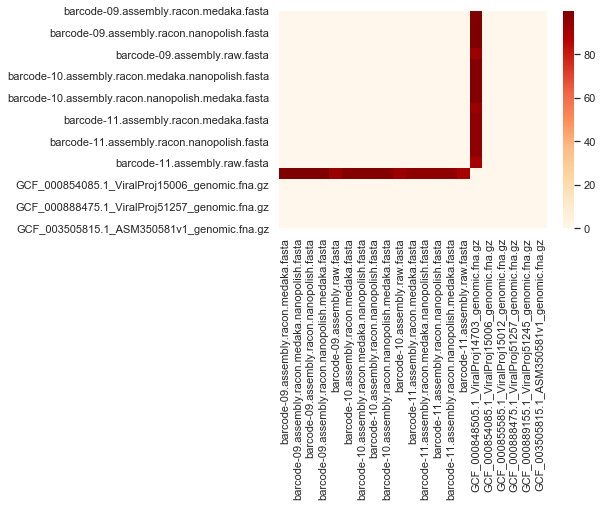

In [3]:
# make the plot
sns.heatmap(df, cmap="OrRd")

> the closest reference genome is `GCF_000848505.1_ViralProj14703_genomic.fna.gz` (which is Mayinga)


### Mayinga

* for ease, move and uncompress the Mayinga reference genome

In [4]:
!find ./ -name GCF_000848505.1_ViralProj14703_genomic.fna.gz -exec gunzip -c {} + > tmp/mayinga-ref-genome.fasta

* calculate the consensus identity for each Mayinga sample compared to the reference
    * this can be calculated from columns 10 and 11 of a PAF alignment file
    * [hengi li's take on sequence identity](https://lh3.github.io/2018/11/25/on-the-definition-of-sequence-identity)

[(80, 100)]

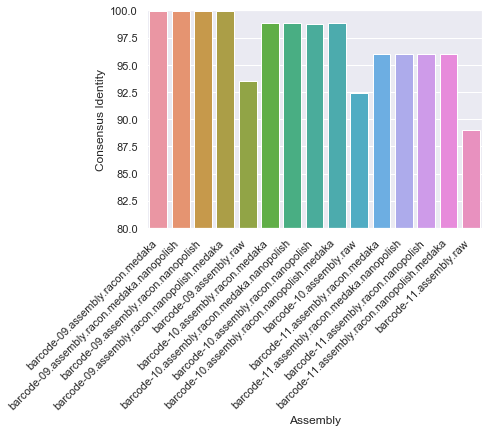

In [5]:
# import the minimap2 binding (mappy)
import mappy as mp

# set up the results list
idents = []

# set up the index
a = mp.Aligner("tmp/mayinga-ref-genome.fasta", preset="asm10")  # load or build index
if not a: raise Exception("ERROR: failed to load/build index")

# open the list of assemblies we made
with open("tmp/r941_min_fast.assembled-genomes.list", "r") as fh:
    
    # align each assembly to the reference
    for line in fh:
        base=os.path.basename(line)
        assemblyName=os.path.splitext(base)[0]
        for name, seq, qual in mp.fastx_read(line.rstrip()):
            
            # get the best hit for each assembly
            topHit = 0.0
            for hit in a.map(seq):
                if (hit.mlen/hit.blen) > topHit:
                    topHit = (hit.mlen/hit.blen) * 100.0
            
            # store for plotting later
            idents.append([assemblyName, topHit])
            
# plot the consensus identities
df = pd.DataFrame(idents, columns = ['Assembly', 'Consensus Identity']) 
chart = sns.barplot(x="Assembly", y="Consensus Identity", data=df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
chart.set(ylim=(80, 100))

* use NucDiff to get some stats on SNPs, InDels and rearrangements

In [6]:
!nucdiff tmp/mayinga-ref-genome.fasta pipelines/data/ebov-dn-assemblies/r941_min_fast/barcode-09.assembly.raw.fasta tmp/nucdiff-out unpolished
!nucdiff tmp/mayinga-ref-genome.fasta pipelines/data/ebov-dn-assemblies/r941_min_fast/barcode-09.assembly.racon.medaka.fasta tmp/nucdiff-out medaka
!nucdiff tmp/mayinga-ref-genome.fasta pipelines/data/ebov-dn-assemblies/r941_min_fast/barcode-09.assembly.racon.medaka.nanopolish.fasta tmp/nucdiff-out medaka-nanopolish
!nucdiff tmp/mayinga-ref-genome.fasta pipelines/data/ebov-dn-assemblies/r941_min_fast/barcode-09.assembly.racon.nanopolish.fasta tmp/nucdiff-out nanopolish
!nucdiff tmp/mayinga-ref-genome.fasta pipelines/data/ebov-dn-assemblies/r941_min_fast/barcode-09.assembly.racon.nanopolish.medaka.fasta tmp/nucdiff-out nanopolish-medaka


Run NUCmer...

1: PREPARING DATA
2,3: RUNNING mummer AND CREATING CLUSTERS
# reading input file "/Users/willrowe/Desktop/signal-check/tmp/nucdiff-out/unpolished.ntref" of length 18960
# construct suffix tree for sequence of length 18960
# (maximum reference length is 536870908)
# (maximum query length is 4294967295)
# CONSTRUCTIONTIME //anaconda3/envs/notebook-analysis/opt/mummer-3.23/mummer /Users/willrowe/Desktop/signal-check/tmp/nucdiff-out/unpolished.ntref 0.00
# reading input file "/Users/willrowe/Desktop/signal-check/pipelines/data/ebov-dn-assemblies/r941_min_fast/barcode-09.assembly.raw.fasta" of length 18634
# matching query-file "/Users/willrowe/Desktop/signal-check/pipelines/data/ebov-dn-assemblies/r941_min_fast/barcode-09.assembly.raw.fasta"
# against subject-file "/Users/willrowe/Desktop/signal-check/tmp/nucdiff-out/unpolished.ntref"
# COMPLETETIME //anaconda3/envs/notebook-analysis/opt/mummer-3.23/mummer /Users/willrowe/Desktop/signal-check/tmp/nucdiff-out/unpolished.ntre

The difference detection inside fragments step is complete

The difference detection between fragments step is complete

Run NUCmer...

1: PREPARING DATA
2,3: RUNNING mummer AND CREATING CLUSTERS
# reading input file "/Users/willrowe/Desktop/signal-check/tmp/nucdiff-out/nanopolish.ntref" of length 18960
# construct suffix tree for sequence of length 18960
# (maximum reference length is 536870908)
# (maximum query length is 4294967295)
# CONSTRUCTIONTIME //anaconda3/envs/notebook-analysis/opt/mummer-3.23/mummer /Users/willrowe/Desktop/signal-check/tmp/nucdiff-out/nanopolish.ntref 0.00
# reading input file "/Users/willrowe/Desktop/signal-check/pipelines/data/ebov-dn-assemblies/r941_min_fast/barcode-09.assembly.racon.nanopolish.fasta" of length 18904
# matching query-file "/Users/willrowe/Desktop/signal-check/pipelines/data/ebov-dn-assemblies/r941_min_fast/barcode-09.assembly.racon.nanopolish.fasta"
# against subject-file "/Users/willrowe/Desktop/signal-check/tmp/nucdiff-out/nanopolish.nt

In [7]:
# nucdiff will report SNPs, InDels and rearrangements, as well as the breadth of coverage, compared to the reference
import glob
from tabulate import tabulate

nucdiffFiles = [i for i in glob.glob('tmp/nucdiff-out/results/*.out')]

dfs = []
for f in nucdiffFiles:
    print(f)
    fn = os.path.basename(f).replace('_stat.out', '')
    df = pd.read_csv(f, sep='\t', header=None, index_col=0)
    df.columns = [fn]
    dfs.append(df)
combined = pd.concat(dfs, axis=1, sort=False)
#stats = combined.loc[ ['Total number', 'Insertions', 'Deletions', 'Substitutions', 'Uncovered ref regions num', 'Uncovered ref regions len'] , : ]
stats = combined.loc[ ['Total number', 'Insertions', 'Deletions', 'Substitutions'] , : ]

print(tabulate(stats, headers='keys', tablefmt='psql'))

tmp/nucdiff-out/results/medaka_stat.out
tmp/nucdiff-out/results/nanopolish_stat.out
tmp/nucdiff-out/results/unpolished_stat.out
tmp/nucdiff-out/results/medaka-nanopolish_stat.out
tmp/nucdiff-out/results/nanopolish-medaka_stat.out
+---------------+----------+--------------+--------------+---------------------+---------------------+
| 0             |   medaka |   nanopolish |   unpolished |   medaka-nanopolish |   nanopolish-medaka |
|---------------+----------+--------------+--------------+---------------------+---------------------|
| Total number  |        6 |           14 |         1311 |                   4 |                   5 |
| Insertions    |        1 |            2 |          339 |                   1 |                   1 |
| Deletions     |        4 |           10 |          466 |                   1 |                   3 |
| Substitutions |        1 |            2 |          506 |                   2 |                   1 |
+---------------+----------+--------------+------

* now let's create a multiple sequence alignment to visualise the differences
 * combine all the polished assemblies into a multifasta and run clustal omega

In [14]:
!cat tmp/mayinga-ref-genome.fasta pipelines/data/ebov-dn-assemblies/r941_min_fast/barcode-09.assembly.racon* > tmp/mayinga-assemblies.fasta


In [15]:
from Bio.Align.Applications import ClustalOmegaCommandline
clustalomega_cline = ClustalOmegaCommandline(infile = "tmp/mayinga-assemblies.fasta", outfile = "tmp/mayinga-assembly-alignment.msa", outfmt = "phylip", verbose = True, auto = False)
clustalomega_cline()

('Using 1 threads\nRead 5 sequences (type: DNA) from tmp/mayinga-assemblies.fasta\nnot more sequences (5) than cluster-size (100), turn off mBed\nCalculating pairwise ktuple-distances...\nKtuple-distance calculation progress: 0 % (0 out of 15)\nKtuple-distance calculation progress: 26 % (4 out of 15)\nKtuple-distance calculation progress: 46 % (7 out of 15)\nKtuple-distance calculation progress: 60 % (9 out of 15)\nKtuple-distance calculation progress: 66 % (10 out of 15)\nKtuple-distance calculation progress done. CPU time: 1.24u 0.00s 00:00:01.24 Elapsed: 00:00:02\nGuide-tree computation done.\nProgressive alignment progress: 25 % (1 out of 4)\nProgressive alignment progress: 50 % (2 out of 4)\nProgressive alignment progress: 75 % (3 out of 4)\nProgressive alignment progress: 100 % (4 out of 4)\nProgressive alignment progress done. CPU time: 60.19u 3.29s 00:01:03.48 Elapsed: 00:01:03\nAlignment written to tmp/mayinga-assembly-alignment.msa\n',
 '')

In [16]:
from Bio import AlignIO
align = AlignIO.read("tmp/mayinga-assembly-alignment.msa", "phylip")
print(align.format("clustal"))

CLUSTAL X (1.81) multiple sequence alignment


NC_002549.                          CGGACACACAAAAAGAAAGAAGAATTTTTAGGATCTTTTGTGTGCGAATA
medaka.con                          --------------------------------------------------
medaka.nan                          --------------------------------------------------
nanopolish                          --------------------------------------------------
nanopolish                          --------------------------------------------------

NC_002549.                          ACTATGAGGAAGATTAATAATTTTCCTCTCATTGAAATTTATATCGGAAT
medaka.con                          ------------------------CCTCTCATTGAAATTTATATCGGAAT
medaka.nan                          ------------------------CCTCTCATTGAAATTTATATCGGAAT
nanopolish                          ------------------------CCTCTCATTGAAATTTATATCGGAAT
nanopolish                          ------------------------CCTCTCATTGAAATTTATATCGGAAT

NC_002549.                          TTAAATTGAAATTGTTACTGTAATCACACCTGGTTTGTTTCAGAG

* clean up all the pipeline files and the tmp directory

In [11]:
!rm -r work/
!rm -r .nextflow*
!rm -r tmp/